In [1]:
# General packages
import numpy as np
import os
import h5py
import seaborn as sns
import matplotlib.pyplot as plt

# Data preparation and validation packages
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy import signal

from PIL import Image
import pandas as pd

from concurrent.futures import ThreadPoolExecutor

# Jupyter interactive plotting
from IPython.display import clear_output
from pathlib import Path

from gwpy.timeseries import TimeSeries

In [2]:
PATH = Path('../../data')
!ls {PATH}

feats.pkl
gspy-db-20180813_O1_filtered_t1126400691-1205493119_snr7.5_tr_gspy.csv
hdf5
input_pipe.pkl
readme.txt
test
test.hdf5
train
train.hdf5
val
val.hdf5


# Train, Val, Test Splitting 

In [3]:
data = pd.read_csv(PATH/'gspy-db-20180813_O1_filtered_t1126400691-1205493119_snr7.5_tr_gspy.csv'); data.head()

,GPStime,peakFreq,snr,centralFreq,duration,bandwidth,id,ifo,label
0,1.134828e+09,32.246,40.137,1601.119,7.250,3183.373047,LYD73IJEbP,H1,Scattered_Light
1,1.134164e+09,29.897,38.256,2965.068,2.500,5894.235352,kQOi8X6807,H1,Scattered_Light
2,1.134478e+09,29.636,32.589,41.479,2.313,47.056068,wypbhS6TAa,H1,Scattered_Light
3,1.134478e+09,31.943,29.462,2532.243,3.000,5035.515137,aKFWKfLE8l,H1,Scattered_Light
4,1.137056e+09,32.552,28.537,1167.148,4.750,2324.383057,yWSM6mnbBM,H1,Scattered_Light


In [4]:
data['ifo'] = data['ifo'].map({l:i for i,l in enumerate(set(data.ifo))})
data['label'] = data['label'].map({l:i for i,l in enumerate(set(data.label))})
data.rename(index=str, columns={'label':'gen_target'}, inplace=True)

In [5]:
df, test = train_test_split(data, test_size=0.33, random_state=7)

In [6]:
from lumin.utils.misc import ids2unique
df['gen_strat_key'] = ids2unique(df[['ifo']].values)

/Users/giles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
val_sz = 0.2
train_df, val_df = train_test_split(df, test_size=val_sz, stratify=df.gen_strat_key, random_state=1111)

# Image proc 

In [8]:
SAMPLE_RATE = 4096.0
K1 = 100/70
NPERSEG = 128
NFFT = 512
WHITEN=True

In [9]:
def whiten(strain:np.ndarray, fft:float=4, overlap:float=2) -> np.ndarray:
    return TimeSeries(strain).whiten(fft, overlap).value

In [10]:
def proc_strain(strain:np.ndarray) -> np.ndarray:
    if WHITEN: strain = whiten(strain)
    _, _, img = signal.spectrogram(strain, window='hann',fs=SAMPLE_RATE, nperseg=NPERSEG, noverlap=NPERSEG//K1, nfft=NFFT)
    img = np.log(np.sqrt(img))
    img = preprocessing.minmax_scale(img)
    img = np.round(255*img).astype(np.uint8)
    img = np.broadcast_to(img[:,:,None],(img.shape[0], img.shape[1],3))
    return img

In [14]:
def create_image(gid:str, label:str, mode:str) -> None:
    for file in os.listdir(PATH/'hdf5/'):
        if gid in file: name = file
    with h5py.File(PATH/f'hdf5/{name}', 'r') as fin: strain = np.array(fin["Strain"]["Strain"].value)
    img = proc_strain(strain)
    Image.fromarray(img, 'RGB').save(PATH/f'images/{mode}/{label}/{gid}.png')

In [15]:
for mode in ['train', 'val', 'test']:
    for l in set(data.gen_target): os.makedirs(PATH/'images'/mode/str(l), exist_ok=True)

In [16]:
def proc_sample(df:pd.DataFrame, mode:str) -> None:
    with ThreadPoolExecutor(8) as e: e.map(create_image, df.id.values, df.gen_target, [mode for _ in range(len(df))])

for i in range(100): create_image(df.id.values[i:i+1][0], df.gen_target.values[i:i+1][0], 'val')

In [17]:
proc_sample(train_df, 'train')

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

In [18]:
proc_sample(train_df, 'val')

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

In [19]:
proc_sample(train_df, 'test')

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/giles/anaconda3/lib/p

# Testing 

In [13]:
for file in os.listdir(PATH/'hdf5/'):
    if 'latS5jv0My' in file: name = file
with h5py.File(PATH/f'hdf5/{name}', 'r') as fin: strain = np.array(fin["Strain"]["Strain"].value)

In [15]:
strain

array([nan, nan, nan, ..., nan, nan, nan])

Text(0, 0.5, 'Strain')

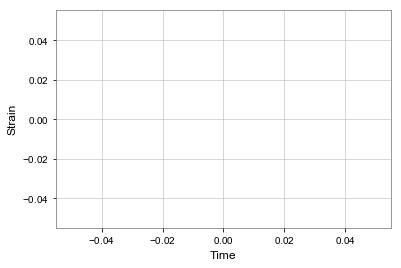

In [14]:
plt.plot(np.arange(len(strain)), strain)
plt.xlabel("Time")
plt.ylabel("Strain")

Text(0, 0.5, 'Strain')

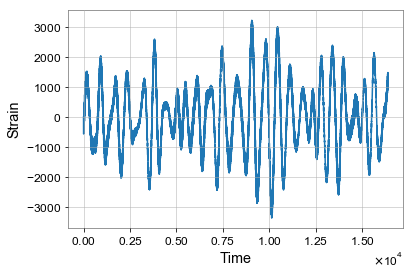

In [119]:
plt.plot(np.arange(len(strain)), whiten(strain, None, None))
plt.xlabel("Time")
plt.ylabel("Strain")

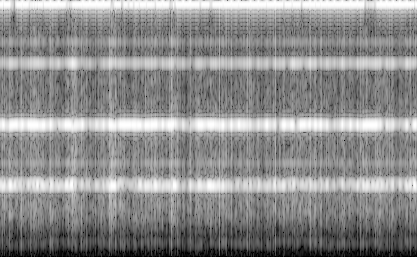

In [74]:
#strain = whiten(strain)
img = proc_strain(strain)
Image.fromarray(img, 'RGB')

In [70]:
img

array([[[195, 195, 195],
        [222, 222, 222],
        [241, 241, 241],
        ...,
        [199, 199, 199],
        [231, 231, 231],
        [216, 216, 216]],

       [[236, 236, 236],
        [240, 240, 240],
        [250, 250, 250],
        ...,
        [221, 221, 221],
        [242, 242, 242],
        [237, 237, 237]],

       [[249, 249, 249],
        [250, 250, 250],
        [253, 253, 253],
        ...,
        [232, 232, 232],
        [248, 248, 248],
        [249, 249, 249]],

       ...,

       [[ 28,  28,  28],
        [ 28,  28,  28],
        [ 55,  55,  55],
        ...,
        [ 13,  13,  13],
        [ 27,  27,  27],
        [  6,   6,   6]],

       [[ 19,  19,  19],
        [ 42,  42,  42],
        [ 34,  34,  34],
        ...,
        [ 10,  10,  10],
        [  0,   0,   0],
        [  7,   7,   7]],

       [[  0,   0,   0],
        [ 38,  38,  38],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [ 15,  15,  15],
        [  0,   0,   0]]

In [75]:
img

array([[[199, 199, 199],
        [222, 222, 222],
        [241, 241, 241],
        ...,
        [199, 199, 199],
        [231, 231, 231],
        [216, 216, 216]],

       [[236, 236, 236],
        [240, 240, 240],
        [250, 250, 250],
        ...,
        [221, 221, 221],
        [242, 242, 242],
        [237, 237, 237]],

       [[249, 249, 249],
        [250, 250, 250],
        [253, 253, 253],
        ...,
        [232, 232, 232],
        [248, 248, 248],
        [249, 249, 249]],

       ...,

       [[ 28,  28,  28],
        [ 28,  28,  28],
        [ 55,  55,  55],
        ...,
        [ 13,  13,  13],
        [ 27,  27,  27],
        [  6,   6,   6]],

       [[ 19,  19,  19],
        [ 42,  42,  42],
        [ 34,  34,  34],
        ...,
        [ 10,  10,  10],
        [  0,   0,   0],
        [  7,   7,   7]],

       [[  0,   0,   0],
        [ 38,  38,  38],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [ 15,  15,  15],
        [  0,   0,   0]]

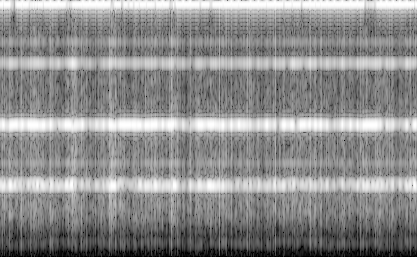

In [67]:
WHITEN=True
img = proc_strain(strain)
Image.fromarray(img, 'RGB')